<a href="https://colab.research.google.com/github/Yugi-Seong/CNN/blob/main/%EC%8B%A4%EC%8A%B53.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CIFAR 10 dataset에 대하여 VGG-19 Classification Network 구현.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/CNN'

/content/drive/MyDrive/CNN


# 셋팅

In [ ]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # cuda : GPU Lib
print(device)

cuda:0


hyperparameter

In [ ]:
# Hyper parameters
num_epochs = 20
num_classes = 10
batch_size = 100
learning_rate = 0.001

# 데이터 준비

In [ ]:
# Data transform & augmentation    데이터 전처리 과정 

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # 이미지의 좌 우 변경 
    transforms.ToTensor(),   #[0,1]값으로 변경 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # 칼러 데이터 정규화를 위해 평균값을 빼줌 
    
])                                                                            

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Data Loader

In [ ]:
# MNIST dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                           train=True, 
                                           transform=transform_train,
                                           download=True)    # data download 

test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                          train=False, 
                                          transform=transform_test)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

Files already downloaded and verified


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
%matplotlib inline

In [ ]:
def imshow(img): 
  img = img/2 + 0.5 
  npimg = img.numpy() 
  plt.imshow(np.transpose(npimg, (1,2,0))) 
  plt.show()


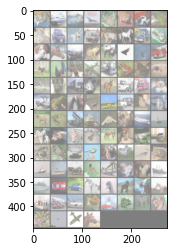

In [ ]:
dataiter = iter(test_loader) 
images, labels = dataiter.next() 
imshow(torchvision.utils.make_grid(images)) 

# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Model

In [ ]:
# 컨볼루션 연산이 2번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_2_block(in_dim,out_dim): # 32 x 32
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),  # 32 x 32 x64
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),          
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),  # 32 x 32  x64
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.MaxPool2d(2,2)  #16 x 16 x64
    )
    return model

  
# 컨볼루션 연산이 4번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_4_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1), 
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),  
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),  
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

## VGG19 Model

In [ ]:
# 위에서 정의한 블록들을 이용해 VGG19 네트워크를 만들어보겠습니다.
# 필터의 개수가 2의 n승의 값을 가지기 때문에 base_dim이란 변수를 추가해서 단순화 했습니다.
# 현재 Cifar10은 10개의 클래스를 구분하려고 하기 때문에 num_classes=10로 설정했습니다.

class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim),
            conv_2_block(base_dim,2*base_dim),
            conv_4_block(2*base_dim,4*base_dim),
            conv_4_block(4*base_dim,8*base_dim),
            conv_4_block(8*base_dim,8*base_dim), # dim = 1 ,1 ,8*64        
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(8*base_dim, 1000), #입력 layer 정의 
            nn.ReLU(True),                                                      # True 는 inplace 연산을 하겠다는 의미를 가집니다. inplace 연산은 결과값을 새로운 변수에 값을 저장하는 대신 기존의 데이터를 대체하는것을 의미합니다.
            nn.Dropout(0.2),
            nn.Linear(1000, 500),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(500, num_classes),
        )

    def forward(self, x):  
        x = self.feature(x)
        x = x.view(x.size(0), -1)  #reshape                                                # x.size(0)를 batch size로 바꿔도 같은 값입니다.
        x = self.fc_layer(x) 
        return x

# Optimizer & Loss

In [ ]:
# gpu가 사용 가능한 경우에는 device를 0번 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 앞서 정의한대로 vGG 클래스를 인스턴스화 하고 지정한 장치에 올립니다.
model = VGG(base_dim=64)
model = model.to(device)

# 손실함수 및 최적화함수를 설정합니다.
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 모델 자녀 노드의 이름과 모듈을 출력합니다.
for i in model.named_children():
    print(i)

cuda:0
('feature', Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Con

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
loss_arr = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)   #이미지와 라벨도 cuda0으로 이동시키기 
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)      
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/20], Step [100/500], Loss: 1.8575
Epoch [1/20], Step [200/500], Loss: 1.7817
Epoch [1/20], Step [300/500], Loss: 1.9405
Epoch [1/20], Step [400/500], Loss: 1.9052
Epoch [1/20], Step [500/500], Loss: 1.6079
Epoch [2/20], Step [100/500], Loss: 1.5322
Epoch [2/20], Step [200/500], Loss: 1.3688
Epoch [2/20], Step [300/500], Loss: 1.5011
Epoch [2/20], Step [400/500], Loss: 1.4026
Epoch [2/20], Step [500/500], Loss: 1.3116
Epoch [3/20], Step [100/500], Loss: 1.1464
Epoch [3/20], Step [200/500], Loss: 1.2777
Epoch [3/20], Step [300/500], Loss: 1.0294
Epoch [3/20], Step [400/500], Loss: 0.9488
Epoch [3/20], Step [500/500], Loss: 0.9870
Epoch [4/20], Step [100/500], Loss: 1.0781
Epoch [4/20], Step [200/500], Loss: 0.9563
Epoch [4/20], Step [300/500], Loss: 0.9404
Epoch [4/20], Step [400/500], Loss: 0.8917
Epoch [4/20], Step [500/500], Loss: 0.8865
Epoch [5/20], Step [100/500], Loss: 0.7489
Epoch [5/20], Step [200/500], Loss: 0.8756
Epoch [5/20], Step [300/500], Loss: 0.9153
Epoch [5/20

In [ ]:
correct = 0
total = 0

# 배치정규화나 드롭아웃은 학습할때와 테스트 할때 다르게 동작하기 때문에 모델을 evaluation 모드로 바꿔서 테스트해야합니다.
model.eval()
with torch.no_grad():
  for image,label in test_loader:
      x = image.to(device)
      y_= label.to(device)

      output = model.forward(x)
      _,output_index = torch.max(output,1)

      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 83.93000030517578
